In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# %matplotlib widget

In [31]:
import h3
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
from src.settings import *
from shapely.geometry import Polygon
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from src.tools.osmnx_utils import get_place_dir_name
from src.tools.h3_utils import get_resolution_buffered_suffix
from pathlib import Path
import plotly.express as px
import umap
from src.tools.clustering import cluster_hdbscan
from src.models.tfidf import tfidf
import matplotlib.pyplot as plt
import contextily as ctx

In [12]:
tqdm.pandas()

In [13]:
place_name = "Wrocław,Poland"
place_dir_name = get_place_dir_name(place_name)
resolution = 9
buffered = True
edges = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"edges_drive_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON")
edges.tail(5)

,id,osmid,h3_id,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,...,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes,geometry
14667,9678,"[ 884068441, 769929444, 727134918, 508232269, ...",891e2040c67ffff,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01744 51.11012, 17.01741 51.110..."
14668,9679,858291159,891e2040c67ffff,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01783 51.11021, 17.01775 51.110..."
14669,9680,875668659,891e204e093ffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04155 51.05842, 17.04163 51.058..."
14670,9681,"[ 923192968, 923192971 ]",891e20462c3ffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.13918 51.16063, 17.13949 51.160..."
14671,9682,925229680,891e20471d3ffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.12107 51.14465, 17.12089 51.144..."


In [14]:
hexagons = gpd.read_file(GENERATED_DATA_DIR.joinpath(place_dir_name, f"hex_{get_resolution_buffered_suffix(resolution, buffered)}.geojson"), driver="GeoJSON").set_index("h3_id")
hexagons.head(5)

,coordinates,parent,children,resolution,geometry
h3_id,,,,,
891e2045463ffff,"(51.09545580515501, 17.10268480221783)",881e204547fffff,"{'8a1e20454617fff', '8a1e20454627fff', '8a1e20...",9,"POLYGON ((17.10016 51.09622, 17.10019 51.09454..."
891e20456b3ffff,"(51.09256633045563, 17.090199278402874)",881e20456bfffff,"{'8a1e20456b27fff', '8a1e20456b37fff', '8a1e20...",9,"POLYGON ((17.08767 51.09333, 17.08771 51.09165..."
891e2041837ffff,"(51.06389906779957, 16.975441510431143)",881e204183fffff,"{'8a1e2041834ffff', '8a1e2041835ffff', '8a1e20...",9,"POLYGON ((16.97292 51.06466, 16.97295 51.06298..."
891e2042d23ffff,"(51.169360089031485, 17.04090812166009)",881e2042d3fffff,"{'8a1e2042d227fff', '8a1e2042d207fff', '8a1e20...",9,"POLYGON ((17.03838 51.17013, 17.03842 51.16845..."
891e2041d0bffff,"(51.07904535087956, 16.97510694306701)",881e2041d1fffff,"{'8a1e2041d0b7fff', '8a1e2041d0affff', '8a1e20...",9,"POLYGON ((16.97258 51.07981, 16.97262 51.07813..."


In [15]:
edges.columns

Index(['id', 'osmid', 'h3_id', 'oneway_0', 'oneway_1', 'lanes_1', 'lanes_2',
       'lanes_3', 'lanes_4', 'lanes_5', 'lanes_6', 'lanes_7',
       'highway_living_street', 'highway_motorway', 'highway_motorway_link',
       'highway_primary', 'highway_primary_link', 'highway_residential',
       'highway_secondary', 'highway_secondary_link', 'highway_tertiary',
       'highway_tertiary_link', 'highway_trunk', 'highway_trunk_link',
       'highway_unclassified', 'maxspeed_10', 'maxspeed_100', 'maxspeed_110',
       'maxspeed_120', 'maxspeed_15', 'maxspeed_20', 'maxspeed_30',
       'maxspeed_40', 'maxspeed_50', 'maxspeed_60', 'maxspeed_70',
       'maxspeed_80', 'maxspeed_90', 'bridge_viaduct', 'bridge_yes',
       'access_delivery', 'access_destination', 'access_no',
       'access_permissive', 'access_yes', 'junction_roundabout', 'width_1.5',
       'width_2', 'width_2.5', 'width_3', 'width_4', 'width_4.5', 'width_6',
       'tunnel_building_passage', 'tunnel_yes', 'geometry'],
      d

In [16]:
hex_feautres = edges.drop(columns="id").groupby(by="h3_id").sum()
hex_feautres

,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,highway_living_street,...,junction_roundabout,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes
h3_id,,,,,,,,,,,,,,,,,,,,,
891e2040007ffff,5,0,0,2,1,0,0,0,0,2,...,0,0,0,0,0,0,0,0,1,0
891e2040013ffff,4,2,0,0,0,0,0,0,0,4,...,2,0,0,0,0,0,0,0,0,0
891e2040017ffff,8,4,0,2,1,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
891e2040023ffff,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2040027ffff,8,5,1,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891e2055b6fffff,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2055b73ffff,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
891e2055b77ffff,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:


hex_features_tfidf = tfidf(hex_feautres)
hex_features_tfidf

,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,highway_living_street,...,junction_roundabout,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes
h3_id,,,,,,,,,,,,,,,,,,,,,
891e2040007ffff,0.470615,0.000000,0.000000,0.300719,0.211734,0.0,0.0,0.0,0.0,0.436089,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.471141,0.0
891e2040013ffff,0.207013,0.196128,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.479564,...,0.455341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
891e2040017ffff,0.450436,0.426753,0.000000,0.179891,0.126659,0.0,0.0,0.0,0.0,0.391304,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
891e2040023ffff,0.522938,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
891e2040027ffff,0.312260,0.369802,0.101102,0.249415,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891e2055b6fffff,0.637404,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
891e2055b73ffff,0.640997,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
891e2055b77ffff,0.640997,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [19]:
mapper = umap.UMAP(n_neighbors=5, metric="cosine").fit(hex_features_tfidf.values)
embedding = mapper.transform(hex_features_tfidf.values)

In [28]:

embedding_df = pd.DataFrame(embedding, columns=["x", "y"])
embedding_df["cluster"] = cluster_hdbscan(embedding_df, min_cluster_size=30, metric="euclidean")
fig = px.scatter(embedding_df, x="x", y="y", color="cluster", width=800, height=700)
fig.show()

In [29]:
embedding_df.index = hex_feautres.index
embedding_df.head(5)

,x,y,cluster
h3_id,,,
891e2040007ffff,9.132862,9.079897,8
891e2040013ffff,-2.517345,6.967883,11
891e2040017ffff,-1.279231,6.667903,11
891e2040023ffff,-0.112925,10.290097,13
891e2040027ffff,0.516194,4.109357,14


In [30]:
hexagons_clustered = hexagons.join(embedding_df)
hexagons_clustered.head(5)

,coordinates,parent,children,resolution,geometry,x,y,cluster
h3_id,,,,,,,,
891e2045463ffff,"(51.09545580515501, 17.10268480221783)",881e204547fffff,"{'8a1e20454617fff', '8a1e20454627fff', '8a1e20...",9,"POLYGON ((17.10016 51.09622, 17.10019 51.09454...",NaN,NaN,NaN
891e20456b3ffff,"(51.09256633045563, 17.090199278402874)",881e20456bfffff,"{'8a1e20456b27fff', '8a1e20456b37fff', '8a1e20...",9,"POLYGON ((17.08767 51.09333, 17.08771 51.09165...",-9.136282,7.649718,-1
891e2041837ffff,"(51.06389906779957, 16.975441510431143)",881e204183fffff,"{'8a1e2041834ffff', '8a1e2041835ffff', '8a1e20...",9,"POLYGON ((16.97292 51.06466, 16.97295 51.06298...",2.041725,4.549371,-1
891e2042d23ffff,"(51.169360089031485, 17.04090812166009)",881e2042d3fffff,"{'8a1e2042d227fff', '8a1e2042d207fff', '8a1e20...",9,"POLYGON ((17.03838 51.17013, 17.03842 51.16845...",NaN,NaN,NaN
891e2041d0bffff,"(51.07904535087956, 16.97510694306701)",881e2041d1fffff,"{'8a1e2041d0b7fff', '8a1e2041d0affff', '8a1e20...",9,"POLYGON ((16.97258 51.07981, 16.97262 51.07813...",3.848619,1.697377,10


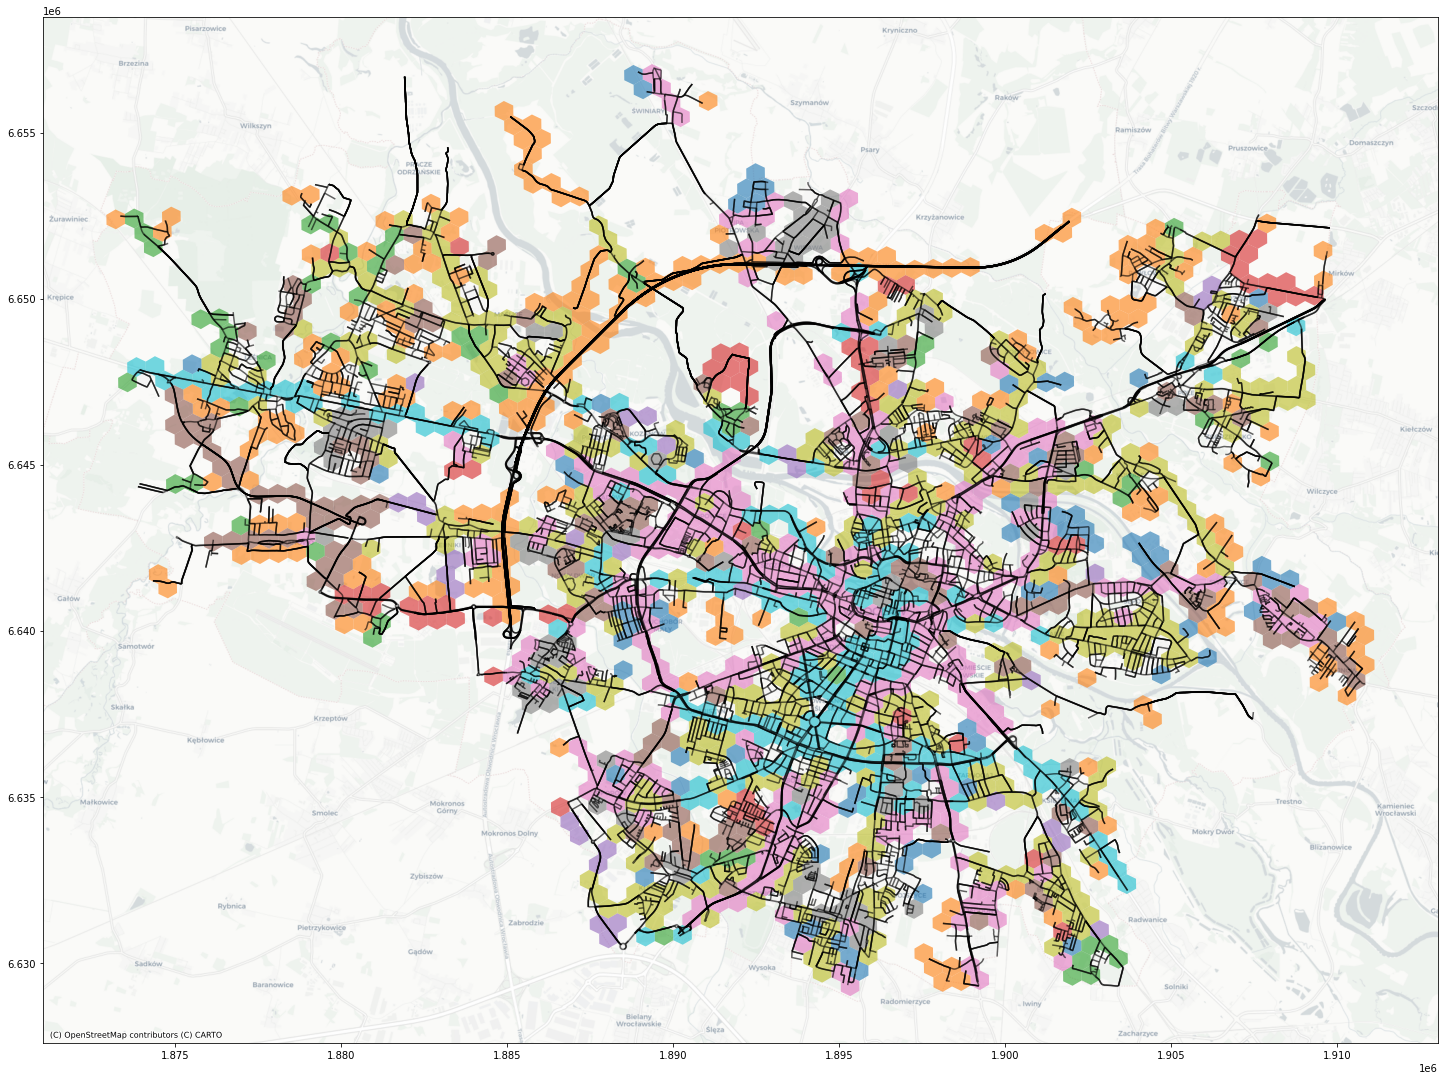

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(25, 23))
ax.set_aspect('equal')
# hex_gdf.plot(column='cluster', ax=ax)
# hexagons_clustered.to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
hexagons_clustered[hexagons_clustered["cluster"] != -1].to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
edges.to_crs(epsg=3857).plot(ax=ax, color="black", alpha=0.6)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

In [ ]:
hex_group_cluster = hex_features_tfidf.join(embedding_df).groupby(by="cluster")

In [ ]:
hex_agg = hex_group_cluster.mean().reset_index()
hex_agg

,cluster,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,lanes_6,lanes_7,...,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes,x,y
0,-1,0.343180,0.109891,0.058319,0.166263,0.048035,0.031050,0.001447,0.000267,0.000141,...,0.000000,0.000646,0.005312,0.009061,0.000791,0.000209,0.001458,0.000784,3.518678,5.728575
1,0,0.640753,0.001747,0.000000,0.001507,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.761888,23.756538
2,1,0.419502,0.000000,0.000000,0.000778,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.622446,16.260904
3,2,0.548816,0.017959,0.000000,0.220766,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.493391,-10.248032
4,3,0.411532,0.129417,0.079457,0.101093,0.116772,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.146808,-10.711261,7.334791
5,4,0.157819,0.261341,0.017381,0.188192,0.080521,0.015957,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.819747,-5.224389
6,5,0.647594,0.007689,0.000000,0.027048,0.003694,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.007929,0.000000,0.000000,0.000000,0.000000,6.877241,16.496046
7,6,0.097279,0.228395,0.009325,0.074775,0.255150,0.306295,0.000000,0.000000,0.021397,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.230285,-2.622994
8,7,0.386808,0.022539,0.005064,0.164613,0.050341,0.007129,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.723867,10.603955
9,8,0.529253,0.003187,0.010818,0.356670,0.165532,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.402634,7.100592


In [ ]:
hex_agg.columns

Index(['cluster', 'oneway_0', 'oneway_1', 'lanes_1', 'lanes_2', 'lanes_3',
       'lanes_4', 'lanes_5', 'lanes_6', 'lanes_7', 'highway_living_street',
       'highway_motorway', 'highway_motorway_link', 'highway_primary',
       'highway_primary_link', 'highway_residential', 'highway_secondary',
       'highway_secondary_link', 'highway_tertiary', 'highway_tertiary_link',
       'highway_trunk', 'highway_trunk_link', 'highway_unclassified',
       'maxspeed_10', 'maxspeed_100', 'maxspeed_110', 'maxspeed_120',
       'maxspeed_15', 'maxspeed_20', 'maxspeed_30', 'maxspeed_40',
       'maxspeed_50', 'maxspeed_60', 'maxspeed_70', 'maxspeed_80',
       'maxspeed_90', 'bridge_viaduct', 'bridge_yes', 'access_delivery',
       'access_destination', 'access_no', 'access_permissive', 'access_yes',
       'junction_roundabout', 'width_1.5', 'width_2', 'width_2.5', 'width_3',
       'width_4', 'width_4.5', 'width_6', 'tunnel_building_passage',
       'tunnel_yes', 'x', 'y'],
      dtype='object')

In [ ]:
fig = px.bar(hex_agg, x="cluster", y=list(filter(lambda x: "bridge" in x, hex_agg.columns)), width=1300)
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
    )
)
fig.show()

In [ ]:
edges

,id,osmid,h3_id,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,...,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes,geometry
0,0,"[ 24707867, 656793686 ]",891e2040b03ffff,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04951 51.08311, 17.04947 51.083..."
1,1,"[ 656794402, 28458110 ]",891e2040b03ffff,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04951 51.08311, 17.04933 51.083..."
2,2,"[ 301726798, 189513998, 301726791 ]",891e2040b07ffff,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.05357 51.08301, 17.05335 51.082..."
3,2,"[ 301726798, 189513998, 301726791 ]",891e2040b03ffff,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.05357 51.08301, 17.05335 51.082..."
4,3,28458112,891e2040b03ffff,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04960 51.08289, 17.04957 51.082..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14669,9678,"[ 884068441, 769929444, 727134918, 508232269, ...",891e2040c6fffff,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01744 51.11012, 17.01741 51.110..."
14670,9679,858291159,891e2040c67ffff,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01783 51.11021, 17.01775 51.110..."
14671,9680,875668659,891e204e093ffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04155 51.05842, 17.04163 51.058..."
14672,9681,"[ 923192968, 923192971 ]",891e20462c3ffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.13918 51.16063, 17.13949 51.160..."


In [ ]:
edges.columns

Index(['id', 'osmid', 'h3_id', 'oneway_0', 'oneway_1', 'lanes_1', 'lanes_2',
       'lanes_3', 'lanes_4', 'lanes_5', 'lanes_6', 'lanes_7',
       'highway_living_street', 'highway_motorway', 'highway_motorway_link',
       'highway_primary', 'highway_primary_link', 'highway_residential',
       'highway_secondary', 'highway_secondary_link', 'highway_tertiary',
       'highway_tertiary_link', 'highway_trunk', 'highway_trunk_link',
       'highway_unclassified', 'maxspeed_10', 'maxspeed_100', 'maxspeed_110',
       'maxspeed_120', 'maxspeed_15', 'maxspeed_20', 'maxspeed_30',
       'maxspeed_40', 'maxspeed_50', 'maxspeed_60', 'maxspeed_70',
       'maxspeed_80', 'maxspeed_90', 'bridge_viaduct', 'bridge_yes',
       'access_delivery', 'access_destination', 'access_no',
       'access_permissive', 'access_yes', 'junction_roundabout', 'width_1.5',
       'width_2', 'width_2.5', 'width_3', 'width_4', 'width_4.5', 'width_6',
       'tunnel_building_passage', 'tunnel_yes', 'geometry'],
      d

In [ ]:
edges

,id,osmid,h3_id,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,...,width_1.5,width_2,width_2.5,width_3,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes,geometry
0,0,"[ 24707867, 656793686 ]",891e2040b03ffff,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04951 51.08311, 17.04947 51.083..."
1,1,"[ 656794402, 28458110 ]",891e2040b03ffff,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04951 51.08311, 17.04933 51.083..."
2,2,"[ 301726798, 189513998, 301726791 ]",891e2040b07ffff,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.05357 51.08301, 17.05335 51.082..."
3,2,"[ 301726798, 189513998, 301726791 ]",891e2040b03ffff,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.05357 51.08301, 17.05335 51.082..."
4,3,28458112,891e2040b03ffff,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04960 51.08289, 17.04957 51.082..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14669,9678,"[ 884068441, 769929444, 727134918, 508232269, ...",891e2040c6fffff,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01744 51.11012, 17.01741 51.110..."
14670,9679,858291159,891e2040c67ffff,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.01783 51.11021, 17.01775 51.110..."
14671,9680,875668659,891e204e093ffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.04155 51.05842, 17.04163 51.058..."
14672,9681,"[ 923192968, 923192971 ]",891e20462c3ffff,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"LINESTRING (17.13918 51.16063, 17.13949 51.160..."


In [ ]:
from src.tools.feature_extraction import melt_and_max

features = ["oneway", "lanes", "maxspeed", "width"]
for column_name in features:
    columns = [x for x in edges.columns if column_name in x]
    edges[column_name] = melt_and_max(edges, column_name, columns)
edges

,id,osmid,h3_id,oneway_0,oneway_1,lanes_1,lanes_2,lanes_3,lanes_4,lanes_5,...,width_4,width_4.5,width_6,tunnel_building_passage,tunnel_yes,geometry,oneway,lanes,maxspeed,width
0,0,"[ 24707867, 656793686 ]",891e2040b03ffff,0,1,0,1,0,0,0,...,0,0,0,0,0,"LINESTRING (17.04951 51.08311, 17.04947 51.083...",1.0,2.0,50.0,0.0
1,1,"[ 656794402, 28458110 ]",891e2040b03ffff,0,1,0,1,0,0,0,...,0,0,0,0,0,"LINESTRING (17.04951 51.08311, 17.04933 51.083...",1.0,2.0,50.0,0.0
2,2,"[ 301726798, 189513998, 301726791 ]",891e2040b07ffff,0,1,0,1,1,1,0,...,0,0,0,0,0,"LINESTRING (17.05357 51.08301, 17.05335 51.082...",1.0,4.0,50.0,0.0
3,2,"[ 301726798, 189513998, 301726791 ]",891e2040b03ffff,0,1,0,1,1,1,0,...,0,0,0,0,0,"LINESTRING (17.05357 51.08301, 17.05335 51.082...",1.0,3.0,50.0,0.0
4,3,28458112,891e2040b03ffff,0,1,0,0,1,0,0,...,0,0,0,0,0,"LINESTRING (17.04960 51.08289, 17.04957 51.082...",0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14669,9678,"[ 884068441, 769929444, 727134918, 508232269, ...",891e2040c6fffff,0,1,0,0,1,0,0,...,0,0,0,0,0,"LINESTRING (17.01744 51.11012, 17.01741 51.110...",NaN,NaN,NaN,NaN
14670,9679,858291159,891e2040c67ffff,0,1,1,0,0,0,0,...,0,0,0,0,0,"LINESTRING (17.01783 51.11021, 17.01775 51.110...",NaN,NaN,NaN,NaN
14671,9680,875668659,891e204e093ffff,1,0,0,0,0,0,0,...,0,0,0,0,0,"LINESTRING (17.04155 51.05842, 17.04163 51.058...",NaN,NaN,NaN,NaN
14672,9681,"[ 923192968, 923192971 ]",891e20462c3ffff,1,0,0,0,0,0,0,...,0,0,0,0,0,"LINESTRING (17.13918 51.16063, 17.13949 51.160...",NaN,NaN,NaN,NaN


In [ ]:
ble2 = edges.drop(columns=["osmid", "h3_id"]).groupby("id").first()

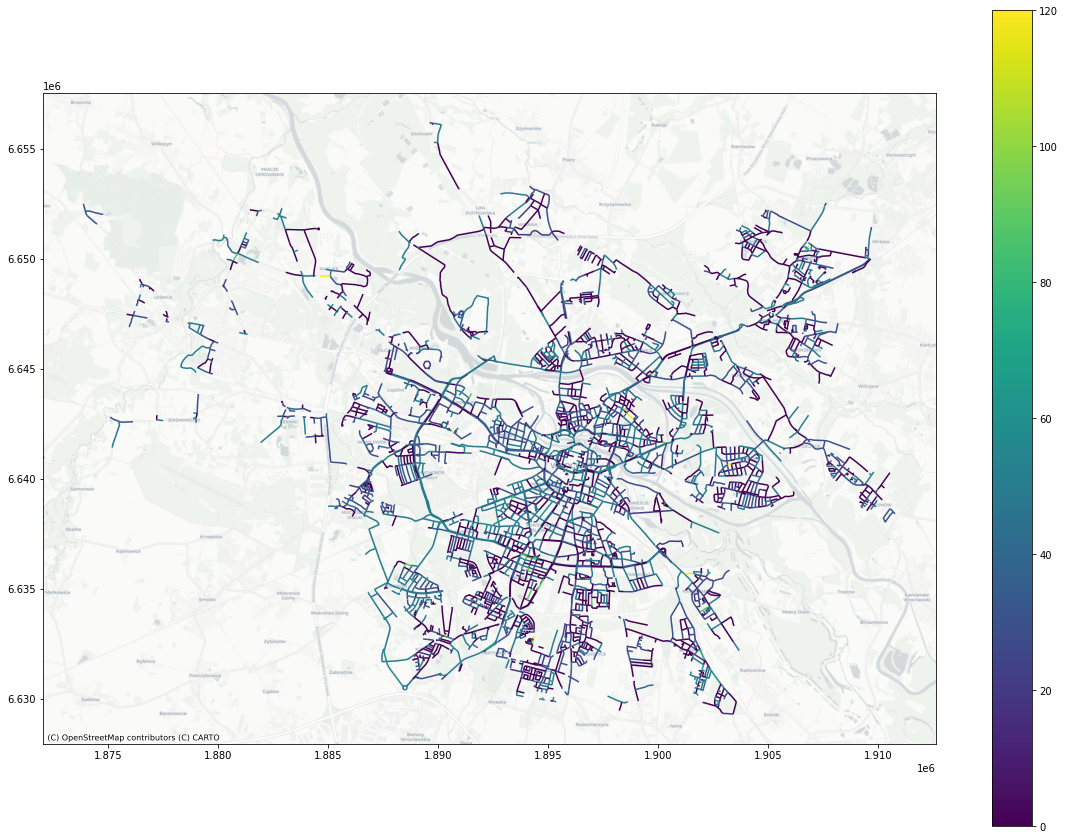

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
ax.set_aspect('equal')
# hex_gdf.plot(column='cluster', ax=ax)
# hexagons_clustered.to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
# hexagons_clustered[hexagons_clustered["cluster"] != -1].to_crs(epsg=3857).plot(column='cluster', ax=ax, alpha=0.6)
ble2["geometry"] = ble2["geometry"].set_crs(epsg=4326)
ble2.to_crs(epsg=3857).plot(ax=ax, column="maxspeed", alpha=1, legend=True)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)